[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)]




#Co-adaptive BCI based on supervised domain adaptation: results in motor imagery simulated data

Notebook credits: Valeria Spagnolo, Catalina Galván, Victoria Peterson

Instituto de Matemática Aplciada del Litoral, IMAL, UNL-CONICET



Notebooks related to the results presented in the X International BCI Meeting, Brussels, 2023

### Demo for testing H1: "BOTDA can make the adaption only if the mental task is performed correctly, regardless of the strengh of the modulation pattern (%ERD)"

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 8.6 MB/s eta 0:00:00
Cloning into 'otda-mibci'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 270 (delta 82), reused 87 (delta 36), pack-reused 120
Receiving objects: 100% (270/270), 82.39 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [3]:
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import*
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mne
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
from  random import sample
from sklearn.metrics import balanced_accuracy_score, accuracy_score
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
import ot

In [4]:
# function to run BOTDA with groupLASSO regularization

def Backward_GroupLasso_Transport(Gtr_daot, Ytr_daot, regu_, Gtr, Ytr, Gval, Yval, Gte, lda, metric):
      
    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)
    botda_cost = botda.cost_
    
    # Compute accuracy without retraining    
    yt_predict = lda.predict(transp_Xt_backward) 
    
    return yt_predict, transp_Xt_backward, botda_matrix, botda_cost

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os.path as op
data_path = op.join('/content/drive/MyDrive/coadaptivesimdata/')

# Load training data - Session 1 - ERD 0.5

In [8]:
# %% Load Training data - session 1
Data_S1 = op.join(data_path, 'session1.fif')
epochs_S1 = mne.read_epochs(Data_S1, preload=True, verbose=False)
# resample to 250 Hz
epochs_S1 = epochs_S1.resample(250)
epochs_S1_array = epochs_S1.get_data()  # Epoched data as a numpy array
# filter data between 8 an 30 hz
epochs_S1_array=mne.filter.filter_data(epochs_S1_array, 250, 8, 30)

ch_names = epochs_S1.ch_names  # Channels names

ERD = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

# Train CSP + LDA decoder

In [9]:
#%% Training - Learn CSP+LDA from source data
Xtr = epochs_S1_array
Ytr = epochs_S1.events[:,2]
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr);

In [10]:
# print LDA score, we expect it to be high
lda.score(Gtr,Ytr)

1.0

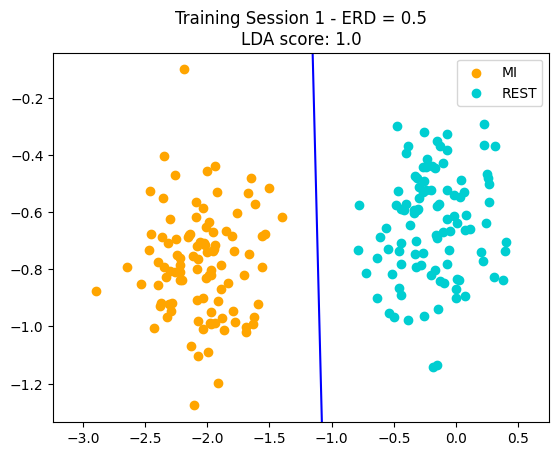

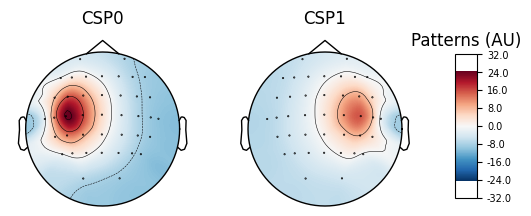

In [11]:
#Plot first 2 features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("Training Session 1 - ERD = " + str(ERD[0]) + "\nLDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)

fig = csp.plot_patterns(epochs_S1.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# Test on Session  - ERD = 0.3

In [13]:
Data_test = op.join(data_path, 'session5.fif')
epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
# resample to 250 Hz
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()
# Filter data 
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

# split val and test data from here already to make the code more easy to follow
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = epochs_test.events[20:,2].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = epochs_test.events[:20,2].copy()

# extract features
Gte=csp.transform(Xte)
Gval=csp.transform(Xval)


In [14]:
# evaluate LDA accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = accuracy_score(Yte,y_predict_lda)

In [15]:
#%% OTDA parameters
rango_cl= [0.1, 1, 10]
rango_e= [0.1, 1, 10]
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

In [17]:
# OT
y_predict_ot = []
Transp = []
associated_cost = []

# select source subset
G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

#initialize val set
Xval_ = Xval.copy()
Yval_ = Yval.copy()
#  For each sample, make the data adaptation
for re in range(1,len(Yte)+1):
    
    # testing trial
    Xte_=Xte[(re-1):(re)]
    Yte_=Yte[(re-1):(re)]
    
    Xval_=np.vstack((Xval_, Xte_))
    Yval_=np.hstack((Yval_, Yte_))
    
    # csp estimation
    Gval_=csp.transform(Xval_)
    Gte_=csp.transform(Xte_)
  
    y_pred_, transp_Xt_backward, botda_matrix, botda_cost = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval_, Yval_, Gte_, lda, metric)
    # save OT prediction
    y_predict_ot.append(y_pred_)
    # save transported data
    Transp.append(transp_Xt_backward)
  
Gte_ot=np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

acc_OT = accuracy_score(Yte,y_predict_ot)

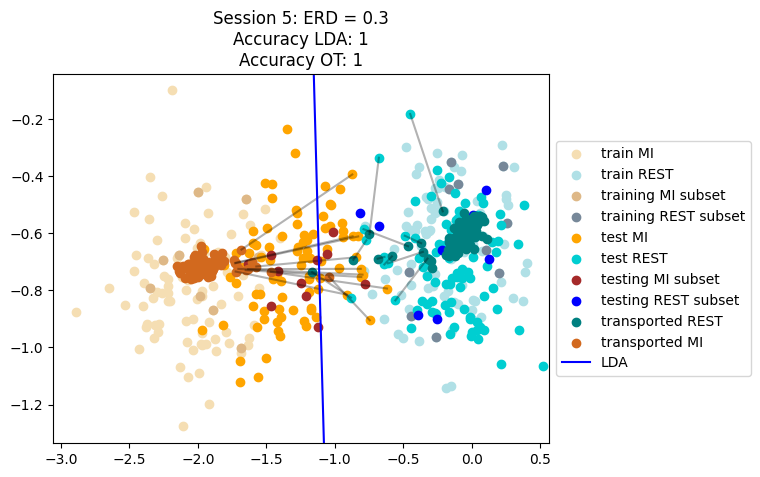

In [19]:
#Plot first 2 features
ft = Gte[:,0:2]
ft_ot = Gte_ot[:,0:2]

acc_lda = round(acc_lda)
acc_OT = round(acc_OT)

x = np.linspace(-1,3,500)
y = np.linspace(2,8,500)
X,Y = np.meshgrid(x,y)
pos = np.array([X.flatten(),Y.flatten()]).T
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='wheat', label='train MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='powderblue', label='train REST')   
# plot the subset where the transport is learned
axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 1], c='burlywood', label='training MI subset')
axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 1], c='lightslategray', label='training REST subset')
axs.scatter(ft[Yte==1, 0], ft[Yte==1, 1], c='orange', label='test MI')  
axs.scatter(ft[Yte==2, 0], ft[Yte==2, 1], c='darkturquoise', label='test REST') 
axs.scatter(Gval[Yval==1, 0], Gval[Yval==1, 1], c='brown', label='testing MI subset')
axs.scatter(Gval[Yval==2, 0], Gval[Yval==2, 1], c='blue', label='testing REST subset')
axs.scatter(ft_ot[Yte==2, 0], ft_ot[Yte==2, 1], c='teal', label='transported REST') 
axs.scatter(ft_ot[Yte==1, 0], ft_ot[Yte==1, 1], c='chocolate', label='transported MI')  
outernMI = np.argsort(ft[Yte==1, 0])[len(ft[Yte==1, 0])-10:]
outernR = np.argsort(ft[Yte==2, 0])[0:10]  
plt.plot([ft[Yte==1, 0][outernMI],ft_ot[Yte==1, 0][outernMI]], [ft[Yte==1, 1][outernMI], ft_ot[Yte==1, 1][outernMI]],'k-', alpha = 0.3)  
plt.plot([ft[Yte==2, 0][outernR],ft_ot[Yte==2, 0][outernR]], [ft[Yte==2, 1][outernR], ft_ot[Yte==2, 1][outernR]],'k-', alpha = 0.3)
            
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue', label = 'LDA')

axs.set_ylim(ylim)
axs.set_xlim(xlim)
axs.set_title('Session 5: ERD = 0.3' + '\nAccuracy LDA: ' + str(acc_lda) + '\nAccuracy OT: ' + str(acc_OT) )  
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
    

Gray connecting lines show euclidean path between the original location of a given trial (in the 2D space) and the final location of the transported trial. When there is modulation patterns, i.e, ERD presence in the trials, BOTDA can perfectly transformed the data to the correspondance class. The "effort", visually measured here by the gray connecting line, would be higher if the trial correspond to a low ERD value.